In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import os,sys
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import pandas as pd
import os
from typing import List, Dict
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
warnings.filterwarnings("ignore")

In [2]:
# 读取数据：最优密码子与蛋白模型的GRU+Attention+mlp数据
file_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/C-P-checkpoints/CaLM+ProtT5.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path)

In [3]:
data

,accuracy,precision,recall,f1,mcc,auc,fold,embedding_model
0,0.767442,0.766304,0.766304,0.766304,0.532609,0.786957,1,CaLM+ProtT5
1,0.732558,0.731315,0.730435,0.730774,0.461749,0.776630,2,CaLM+ProtT5
2,0.732558,0.731436,0.732065,0.731651,0.463501,0.805978,3,CaLM+ProtT5
3,0.802326,0.808238,0.807065,0.802299,0.615302,0.863587,4,CaLM+ProtT5
4,0.720930,0.724457,0.724457,0.720930,0.448913,0.773370,5,CaLM+ProtT5
5,0.755814,0.755000,0.750409,0.751753,0.505388,0.809056,6,CaLM+ProtT5
6,0.709302,0.713587,0.714403,0.709263,0.427989,0.735406,7,CaLM+ProtT5
7,0.670588,0.673611,0.674192,0.670543,0.347802,0.719064,8,CaLM+ProtT5
8,0.752941,0.754712,0.756132,0.752804,0.510841,0.801003,9,CaLM+ProtT5
9,0.776471,0.781773,0.781773,0.776471,0.563545,0.829431,10,CaLM+ProtT5


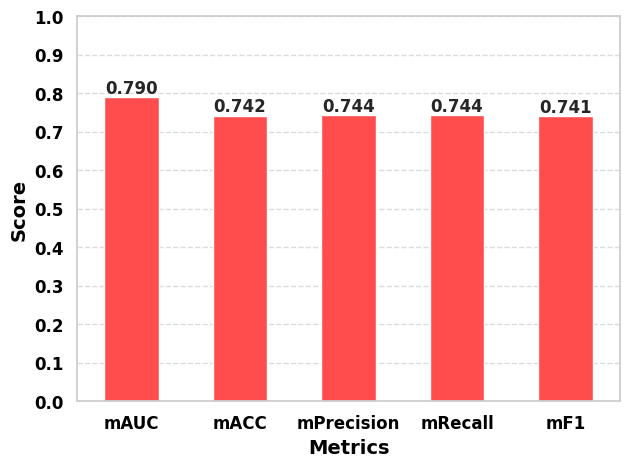

In [6]:
# 读取数据：最优密码子与蛋白模型的GRU+Attention+mlp数据
file_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/C-P-checkpoints/CaLM+ProtT5.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path)
# 计算每个指标的平均值
mean_values = data[['auc','accuracy', 'precision', 'recall', 'f1']].mean()
mean_values = mean_values.rename({"auc":"mAUC","accuracy":"mACC","precision":"mPrecision", "recall":"mRecall", "f1":"mF1"})

sns.set_theme(style="whitegrid")

# 画柱状图
plt.figure(figsize=(7, 5))
mean_values.plot(kind='bar', color=['#FF4D4D', '#FF4D4D', '#FF4D4D', '#FF4D4D', '#FF4D4D'])

# 设置 Y 轴范围
# plt.ylim(0.60, 0.85)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.yticks(color='black', fontsize=12, fontweight='bold')

# 设置标题和标签
# plt.title('Average Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis="x")  # 关闭 x 轴网格线
plt.xticks(rotation=0, ha="center", color='black', fontsize=12, fontweight='bold')

plt.xlabel("Metrics", fontsize=14, fontweight='bold', color='black')

# 显示数值标签
for i, v in enumerate(mean_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=12, fontweight='bold')

# 添加图例
# model_name="CaLM+ProtT5"
# plt.legend(facecolor='white', edgecolor='black', fontsize=10, frameon=True, shadow=True, prop={'weight': 'bold', 'size': 10})  # 设置图例
# plt.legend([model_name], facecolor='white', edgecolor='black', fontsize=10, frameon=True, shadow=True, prop={'weight': 'bold', 'size': 10})  # 设置图例

plt.show()

Successfully saved results/TLCP-EPE_AUC_PRC_data.csv
Successfully saved results/TLC-EPE_AUC_PRC_data.csv
Successfully saved results/TLP-EPE_AUC_PRC_data.csv

Statistics for TLCP-EPE model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']

Statistics for TLC-EPE model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']

Statistics for TLP-EPE model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']


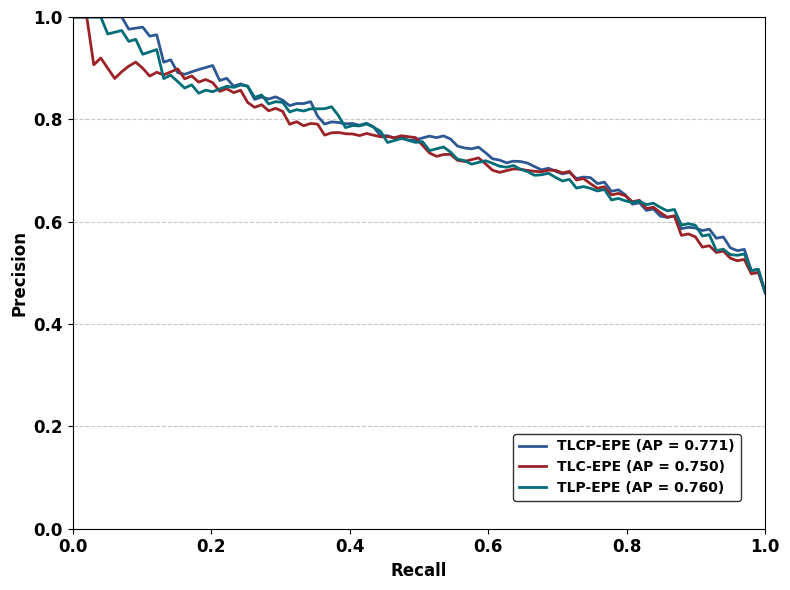

In [85]:
def load_and_process_data(file_paths: Dict[str, str]) -> Dict[str, Dict[str, List]]:
    """
    加载并处理多个模型的数据，计算ROC和PRC曲线数据
    """
    results = {}
    mean_fpr = np.linspace(0, 1, 100)
    
    for model_name, file_path in file_paths.items():
        if not os.path.exists(file_path):
            print(f"警告：文件 {file_path} 不存在，跳过该模型")
            continue
            
        try:
            df = pd.read_csv(file_path)
            required_columns = {'fold', 'y_true', 'prob_class_1'}
            if not required_columns.issubset(df.columns):
                print(f"警告：文件 {file_path} 缺少必要的列")
                continue
                
            folds = sorted(df['fold'].unique())
            tprs = []
            aucs = []
            precisions = []
            recalls = []
            pr_aucs = []
            
            # 计算每个fold的ROC和PRC数据
            for fold in folds:
                fold_data = df[df['fold'] == fold]
                y_true_fold = fold_data['y_true'].values
                prob_class_1_fold = fold_data['prob_class_1'].values
                
                # ROC数据
                fpr, tpr, _ = roc_curve(y_true_fold, prob_class_1_fold)
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                
                # PRC数据
                precision, recall, _ = precision_recall_curve(y_true_fold, prob_class_1_fold)
                pr_auc = average_precision_score(y_true_fold, prob_class_1_fold)
                pr_aucs.append(pr_auc)
                
                # 对precision进行插值
                mean_recall = np.linspace(0, 1, 100)
                interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
                precisions.append(interp_precision)
            
            # 计算平均值和标准差
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            
            mean_precision = np.mean(precisions, axis=0)
            mean_pr_auc = np.mean(pr_aucs)
            std_pr_auc = np.std(pr_aucs)
            
            results[model_name] = {
                'mean_fpr': mean_fpr,
                'mean_tpr': mean_tpr,
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'mean_recall': mean_recall,
                'mean_precision': mean_precision,
                'mean_pr_auc': mean_pr_auc,
                'std_pr_auc': std_pr_auc
            }
            
        except Exception as e:
            print(f"处理 {model_name} 模型时发生错误：{str(e)}")
            continue
    
    return results

# 文件路径配置
base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/results"
# 确保文件路径字典和颜色字典的键名一致
file_paths = {
    'TLCP-EPE': f"{base_path}/TLCP-EPE_AUC_PRC_data.csv",
    'TLC-EPE': f"{base_path}/TLC-EPE_AUC_PRC_data.csv",
    'TLP-EPE': f"{base_path}/TLP-EPE_AUC_PRC_data.csv"
}
colors = {
    'TLCP-EPE': '#2E5894',
    'TLC-EPE': '#9B2226',
    'TLP-EPE': '#006D77'
}
results = load_and_process_data(file_paths)

curve_type="prc"
plt.figure(figsize=(8, 6))
    # 设置字体样式为 Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sns.set_theme(style="ticks", context="paper")
plt.style.use('default')

# 绘制每个模型的ROC曲线
for model_name, data in results.items():
    color = colors[model_name]
    if curve_type == 'roc':        
        plt.plot(data['mean_fpr'], data['mean_tpr'], color=color, lw=2,
                    label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')
    else:  # PRC
        # pr_auc = auc(data['mean_recall'], data['mean_precision'])
        plt.plot(data['mean_recall'], data['mean_precision'], color=color, lw=2,
                    label=f'{model_name} (AP = {data["mean_pr_auc"]:.3f})')

# 设置图表参数
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks(np.arange(0, 1.1, 0.2))
    
if curve_type == "roc":
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    # 设置标签和样式
    plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold', color='black')
    plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold', color='black')
else:
    plt.xlabel('Recall', fontsize=12, fontweight='bold', color='black')
    plt.ylabel('Precision', fontsize=12, fontweight='bold', color='black')
    
plt.legend( loc="center",
                facecolor='white',
                edgecolor='black',
                fontsize=8,
                frameon=True,
                bbox_to_anchor=(0.8, 0.12),
                prop={'weight': 'bold', 'size': 10}
                )
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis="x")
plt.xticks(rotation=0, ha="center", color='black', fontsize=12, fontweight='bold')
plt.yticks(color='black', fontsize=12, fontweight='bold')
plt.tight_layout()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

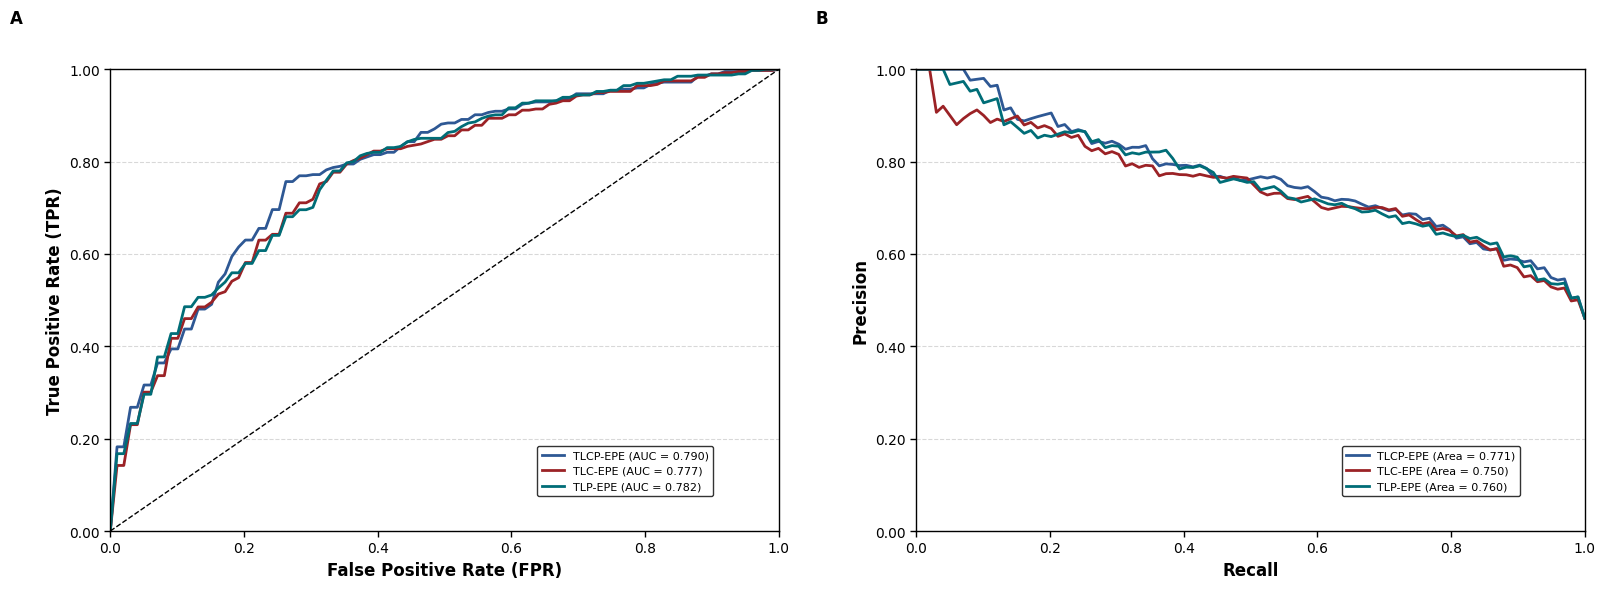

In [91]:
# 设置字体样式为 Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 创建一个包含两个子图的图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 设置 Seaborn 样式
sns.set_theme(style="ticks", context="paper")
plt.style.use('default')

# 第一个子图 - ROC曲线
for model_name, data in results.items():
    ax1.plot(data['mean_fpr'], data['mean_tpr'], 
            color=colors[model_name], 
            lw=2,
            markersize=6,
            markevery=0.1,
            label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')

# 设置第一个子图的属性
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
ax1.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
ax1.grid(False, axis='x')

# 第二个子图 - PRC曲线
for model_name, data in results.items():
    ax2.plot(data['mean_recall'], data['mean_precision'], 
            color=colors[model_name], 
            lw=2,
            markersize=6,
            markevery=0.1,
            label=f'{model_name} (Area = {data["mean_pr_auc"]:.3f})')

# 设置第二个子图的属性
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
ax2.grid(False, axis='x')

# 设置刻度属性
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
    ax.tick_params(axis='both', which='minor', width=1, length=2)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    # 设置刻度范围和间隔
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    
    # 设置边框线宽
    for spine in ax.spines.values():
        spine.set_linewidth(1)

# 设置图例
legend1 = ax1.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=8,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

legend2 = ax2.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=8,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

# 添加子图标签 A 和 B
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')

# 调整布局
plt.tight_layout(w_pad=3.0)


In [96]:
plot_df

,Metric,Value,Model
0,AUC,0.804891,CaLM
1,AUC,0.752174,CaLM
2,AUC,0.795652,CaLM
3,AUC,0.852717,CaLM
4,AUC,0.742391,CaLM
...,...,...,...
145,Accuracy,0.755814,CaLM+ProtT5
146,Accuracy,0.709302,CaLM+ProtT5
147,Accuracy,0.670588,CaLM+ProtT5
148,Accuracy,0.752941,CaLM+ProtT5


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
calm_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/results/TLC-EPE-checkpoints/CaLM.csv')
calm_prot_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/results/TLCP-EPE-checkpoints/CaLM+ProtT5.csv')
prot_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/results/TLP-EPE-checkpoints/ProtT5.csv')

# 准备数据
metrics = ['auc', 'precision', 'recall', 'f1', 'accuracy']
models = ['CaLM', 'ProtT5', 'CaLM+ProtT5']

# 创建一个新的DataFrame用于绘图
plot_data = []
for metric in metrics:
    for model in models:
        if model == 'CaLM':
            data = calm_df[metric]
        elif model == 'CaLM+ProtT5':
            data = calm_prot_df[metric]
        else:
            data = prot_df[metric]
        
        for value in data:
            plot_data.append({
                'Metric': metric.upper() if metric == 'auc' else metric.capitalize(),
                'Value': value,
                'Model': model
            })

plot_df = pd.DataFrame(plot_data)
plot_df["Model"] = plot_df.Model.str.replace("CaLM+ProtT5","TLCP-EPE")
plot_df["Model"] = plot_df.Model.str.replace("CaLM","TLC-EPE")
plot_df["Model"] = plot_df.Model.str.replace("ProtT5","TLP-EPE")


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

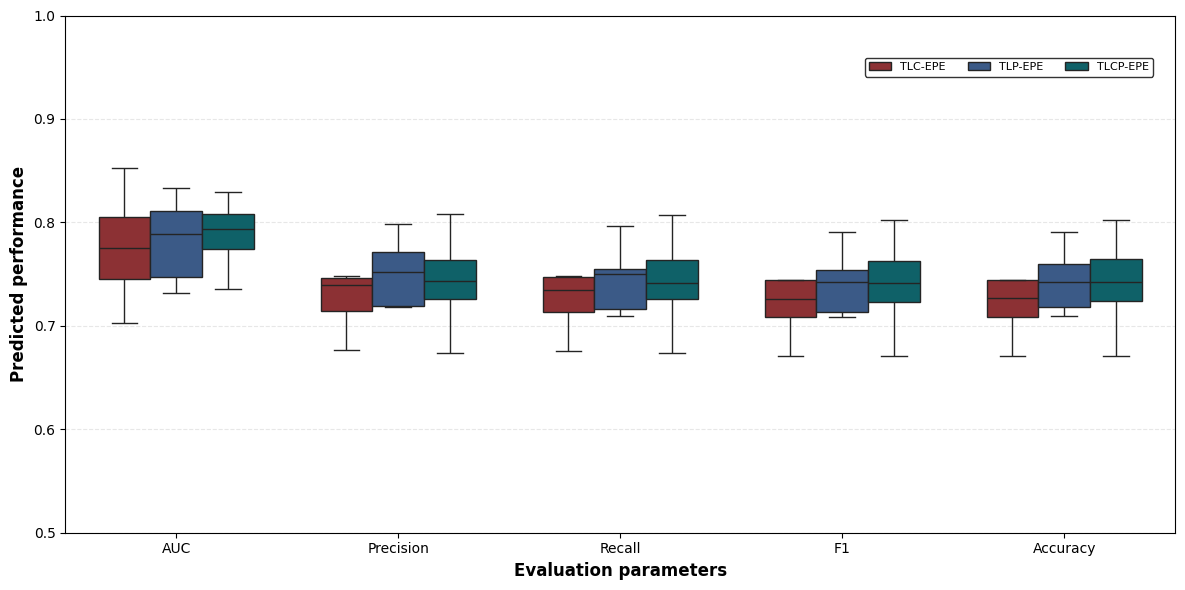

In [132]:
# 设置绘图样式
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 设置颜色
colors = ['#9B2226', '#2E5894', '#006D77']

# 创建箱线图
sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
            palette=colors, width=0.7, showfliers=False)

# 设置图表属性
plt.xlabel('Evaluation parameters', fontsize=12, fontweight='bold')
plt.ylabel('Predicted performance', fontsize=12, fontweight='bold')
plt.ylim(0.5, 1)

# 设置图例（调整为一行）
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:3],
    labels[:3], 
    facecolor='white',
    edgecolor='black',
    fontsize=8,
    frameon=True,
    loc='center', 
    bbox_to_anchor=(0.85, 0.9),
    ncol=3  # 将图例设置为一行
)

# 设置网格
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.grid(False, axis='x')

# 设置刻度
plt.tick_params(axis='both', which='major', labelsize=10)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [10]:
# Load data
file_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/AUC_PRC_data.csv"
df = pd.read_csv(file_path)

# Get unique fold numbers and sort them
folds = sorted(df['fold'].unique())

# Store ROC data for each fold
roc_data = {}
for fold in folds:
    fold_data = df[df['fold'] == fold]
    y_true_fold = fold_data['y_true'].values
    prob_class_1_fold = fold_data['prob_class_1'].values
    fpr, tpr, _ = roc_curve(y_true_fold, prob_class_1_fold)
    roc_auc = auc(fpr, tpr)
    roc_data[fold] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}



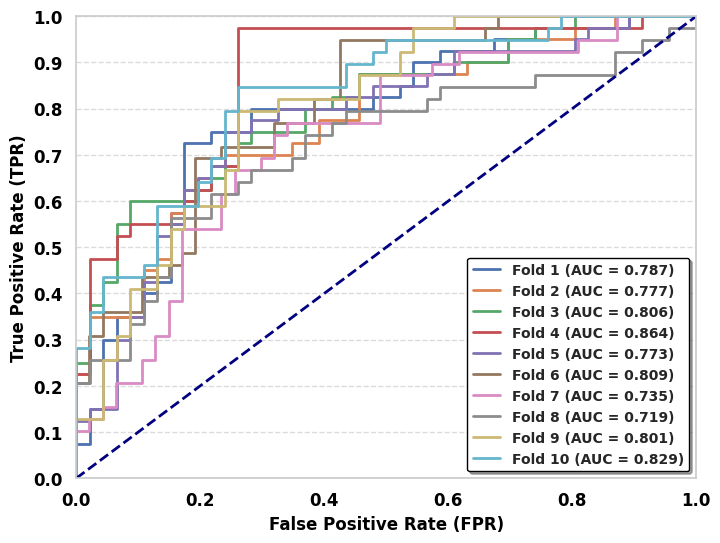

每个折的AUC值：
fold
1     0.786957
2     0.776630
3     0.805978
4     0.863587
5     0.773370
6     0.809056
7     0.735406
8     0.719064
9     0.801003
10    0.829431
dtype: float64
平均AUC: 0.7900, AUC标准差: 0.0424


In [11]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for fold in folds:
    data = roc_data[fold]
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'Fold {fold} (AUC = {data["auc"]:.3f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks(np.arange(0, 1.1, 0.1))

# Set labels and styles
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold', color='black')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold', color='black')
plt.legend(loc="lower right", facecolor='white', edgecolor='black', fontsize=10, frameon=True, shadow=True, prop={'weight': 'bold', 'size': 10})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis="x")  # 关闭 x 轴网格线
plt.xticks(rotation=0, ha="center", color='black', fontsize=12, fontweight='bold')
plt.yticks(color='black', fontsize=12, fontweight='bold')

# Display the plot
plt.show()

# 可选：计算AUC统计
auc_per_fold = df.groupby('fold').apply(lambda x: roc_auc_score(x['y_true'], x['prob_class_1']))
mean_auc = auc_per_fold.mean()
std_auc = auc_per_fold.std()
print("每个折的AUC值：")
print(auc_per_fold)
print(f"平均AUC: {mean_auc:.4f}, AUC标准差: {std_auc:.4f}")

In [12]:
# 加载数据
file_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/AUC_PRC_data.csv"
df = pd.read_csv(file_path)
# 获取唯一的折编号并排序
folds = sorted(df['fold'].unique())  # 排序以确保图例顺序一致

In [15]:
df

,fold,y_true,y_pred,prob_class_0,prob_class_1,source_file
0,1,0,0,0.805561,0.194439,fold_1_predictions.csv
1,1,1,0,0.792293,0.207707,fold_1_predictions.csv
2,1,1,1,0.342415,0.657585,fold_1_predictions.csv
3,1,0,0,0.651601,0.348399,fold_1_predictions.csv
4,1,1,0,0.529335,0.470665,fold_1_predictions.csv
...,...,...,...,...,...,...
852,10,0,1,0.275202,0.724798,fold_10_predictions.csv
853,10,1,0,0.746288,0.253712,fold_10_predictions.csv
854,10,1,1,0.107541,0.892459,fold_10_predictions.csv
855,10,0,1,0.237652,0.762348,fold_10_predictions.csv


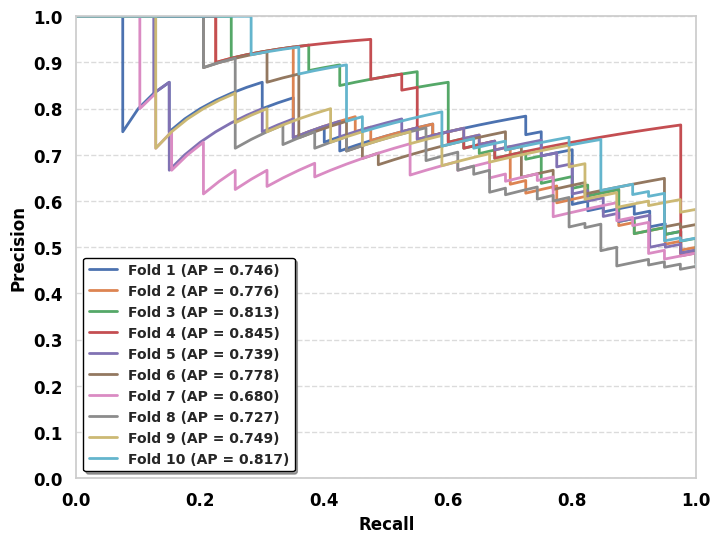

每个折的 AP 值：
fold
1     0.751612
2     0.778959
3     0.815554
4     0.847642
5     0.743913
6     0.781265
7     0.685770
8     0.730488
9     0.753487
10    0.819261
dtype: float64
平均 AP (逐折计算): 0.7708, AP 标准差: 0.0479


In [13]:
# 创建图表
plt.figure(figsize=(8, 6))

# 存储每个折的 PR 数据和 AP 值
pr_data = {}
for fold in folds:
    fold_data = df[df['fold'] == fold]
    y_true_fold = fold_data['y_true'].values
    prob_class_1_fold = fold_data['prob_class_1'].values
    
    # 计算 PR 曲线
    precision, recall, _ = precision_recall_curve(y_true_fold, prob_class_1_fold)
    pr_auc = auc(recall, precision)
    
    # 存储数据
    pr_data[fold] = {'precision': precision, 'recall': recall, 'ap': pr_auc}
    
    # 绘制每折的 PR 曲线
    plt.plot(recall, precision, lw=2, label=f'Fold {fold} (AP = {pr_auc:.3f})')

# 设置图表属性（与上一个模板一致）
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks(np.arange(0, 1.1, 0.1))


plt.xlabel('Recall', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Precision', fontsize=12, fontweight='bold', color='black')
# plt.title('Precision-Recall Curves for Each Fold', fontsize=14, fontweight='bold', color='black')
plt.legend(loc="lower left", facecolor='white', edgecolor='black', fontsize=10, frameon=True, shadow=True, prop={'weight': 'bold', 'size': 10})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis="x")  # 关闭 x 轴网格线
plt.xticks(rotation=0, ha="center", color='black', fontsize=12, fontweight='bold')
plt.yticks(color='black', fontsize=12, fontweight='bold')

# 显示图表
plt.show()

# 计算并输出每个折的 AP 统计
ap_per_fold = df.groupby('fold').apply(lambda x: average_precision_score(x['y_true'], x['prob_class_1']))
mean_ap_per_fold = ap_per_fold.mean()
std_ap = ap_per_fold.std()
print("每个折的 AP 值：")
print(ap_per_fold)
print(f"平均 AP (逐折计算): {mean_ap_per_fold:.4f}, AP 标准差: {std_ap:.4f}")

In [28]:
calm_t5 = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLPREco/DLs/checkpoints-2-8-calm-t5/Finetune_calm+prot_t5.csv")
t5 = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLPREco/DLs/checkpoints-2-8-t5/prot_t5_xl_uniref50.csv")
calm = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLPREco/DLs/checkpoints-2-8-calm/huggingface_calm.csv")

calm = calm[["accuracy", "precision", "recall", "f1", "auc"]].mean().to_frame().T
calm["Model"] = "Codon Model(CaLM)"
t5 = t5[["accuracy", "precision", "recall", "f1", "auc"]].mean().to_frame().T
t5["Model"] = "Protein Model(ProtT5)"
calm_t5 = calm_t5[["accuracy", "precision", "recall", "f1", "auc"]].mean().to_frame().T
calm_t5["Model"] = "Codon-Protein Model(CaLM-ProtT5)"

all_calm_t5 = pd.concat([ calm, t5, calm_t5])

all_calm_t5 = all_calm_t5.rename( columns={"accuracy":"mACC", "precision":"mPrecision", "recall":"mRecall", "f1":"mF1", "auc":"mAUC"} )

calm_protein_metrics_embeddings = all_calm_t5.melt(
    id_vars=['Model'],            # 保持不变的列
    var_name='Metrics',          # 度量指标的列名
    value_name='Score'           # 值的列名
).reset_index(drop=True)

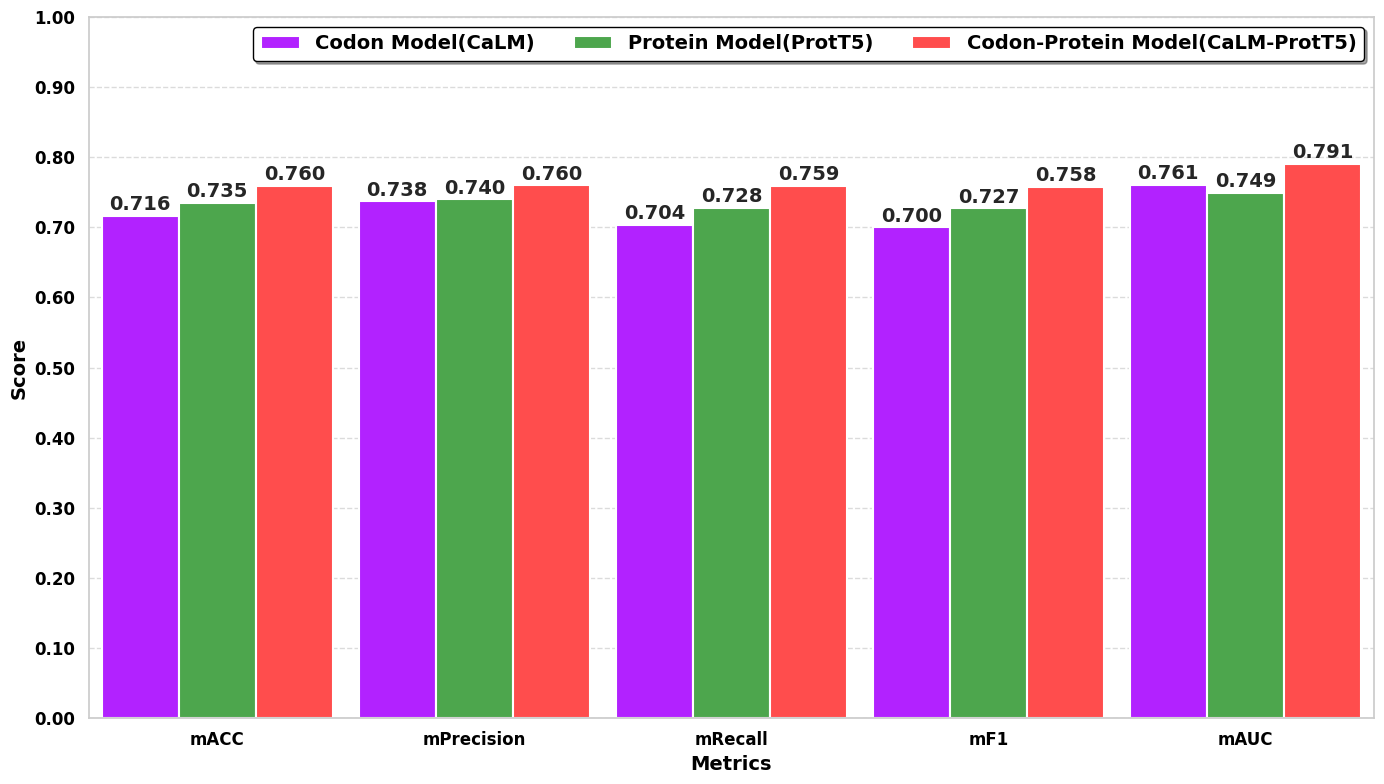

In [29]:
df = calm_protein_metrics_embeddings
# 自定义颜色列表
custom_palette = ['#B222FF', '#4DA64D', '#FF4D4D']

# 设置 Seaborn 样式
sns.set_theme(style="whitegrid")

# 创建图形
plt.figure(figsize=(14, 8))

# 绘制条形图
barplot = sns.barplot(
    x="Metrics", 
    y="Score", 
    hue="Model", 
    data=df,
    palette=custom_palette,
    linewidth=1.5,
    width=0.9,
    saturation=1.0
)

# # 添加数值标签
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', padding=1, fontsize=14, fontweight='bold')

# 设置 y 轴范围（稍微增加上限以容纳标签）
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# 设置 y 轴刻度格式（显示两位小数）
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# 设置坐标轴标签
plt.xlabel("Metrics", fontsize=14, fontweight='bold', color='black')
plt.ylabel("Score", fontsize=14, fontweight='bold', color='black')

# 调整 x 轴和 y 轴的刻度字体颜色，并加粗
plt.xticks(rotation=0, ha="center", color='black', fontsize=12, fontweight='bold')
plt.yticks(color='black', fontsize=12, fontweight='bold')

# 设置图例
n_models = len(df['Model'].unique())
legend = plt.legend(
    facecolor='white', 
    edgecolor='black', 
    fontsize=14, 
    frameon=True, 
    shadow=True, 
    ncol=n_models
)
plt.setp(legend.get_texts(), color='black', fontweight='bold')

# 添加网格线样式
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()